In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\smaiya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Overview

In [2]:
users = pd.read_csv('data/takehome_users.csv', encoding = 'ISO-8859-1')
login = pd.read_csv('data/takehome_user_engagement.csv', encoding = 'ISO-8859-1')

**Shape & first few observations of the data** 

In [3]:
users.shape, login.shape

((12000, 10), (207917, 3))

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
login.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Data Preprocessing

**Obtaining one unified merged DataFrame** 

In [6]:
all_data = pd.merge(login, users, how='left', left_on='user_id', right_on='object_id')
all_data.head()

,time_stamp,user_id,visited,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,2014-04-22 03:53:30,1,1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2013-11-15 03:45:04,2,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,2013-11-29 03:45:04,2,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-12-09 03:45:04,2,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
4,2013-12-25 03:45:04,2,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [7]:
all_data.shape

(207917, 13)

**Converting into datetime object**  

In [8]:
all_data.time_stamp = pd.to_datetime(all_data.time_stamp)
all_data = all_data.set_index('time_stamp')
all_data.info()
#all_data.loc['2014-04-22':'2014-04-22']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 12 columns):
user_id                       207917 non-null int64
visited                       207917 non-null int64
object_id                     207917 non-null int64
creation_time                 207917 non-null object
name                          207917 non-null object
email                         207917 non-null object
creation_source               207917 non-null object
last_session_creation_time    207917 non-null float64
opted_in_to_mailing_list      207917 non-null int64
enabled_for_marketing_drip    207917 non-null int64
org_id                        207917 non-null int64
invited_by_user_id            116887 non-null float64
dtypes: float64(2), int64(6), object(4)
memory usage: 20.6+ MB


## Handling Missing Fields

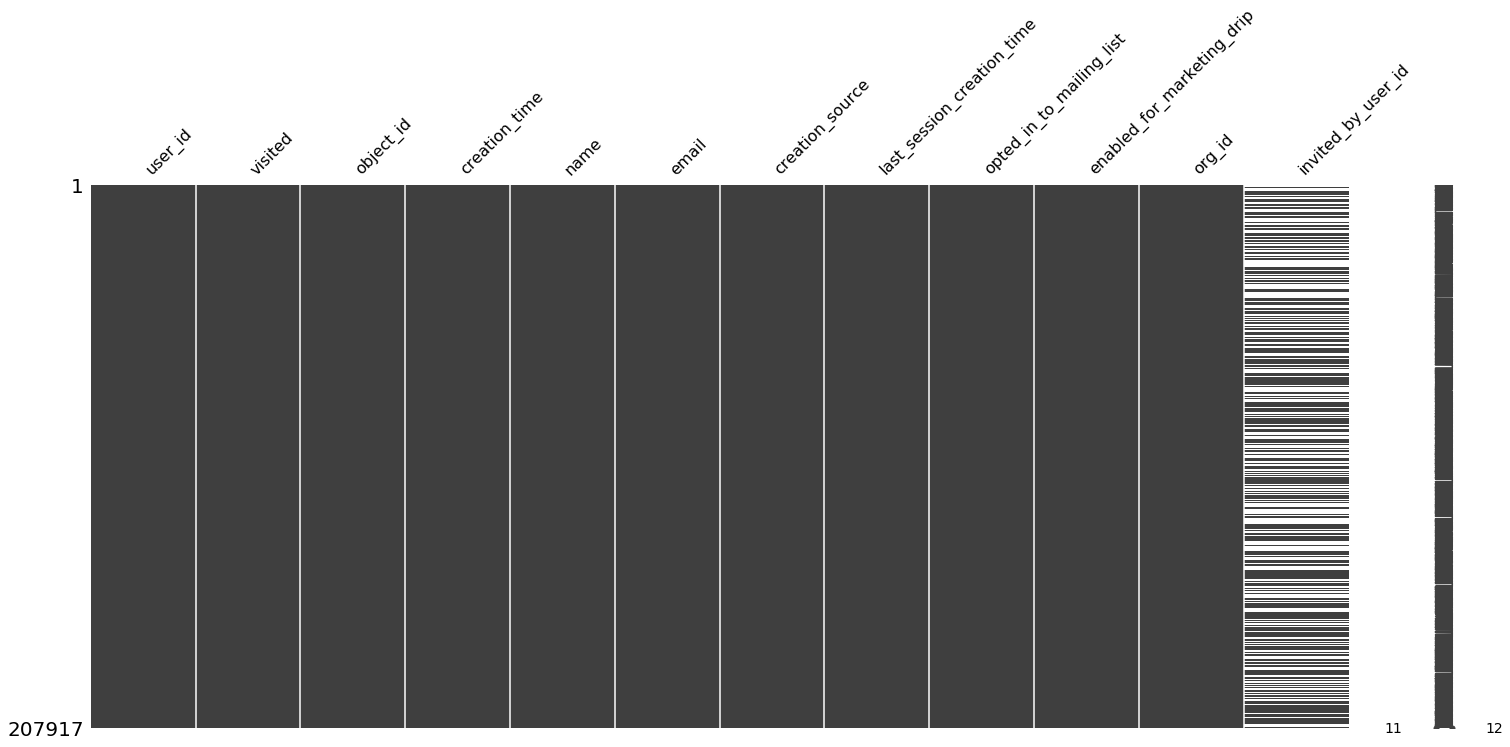

In [9]:
msno.matrix(all_data)

Only column with missing data field is invited_by_user_id. 

In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Users has null entries for last_session_creation_time, but the merged dataframe, data, doesnt. Confirming that the user_ids in users dataframe with null last_session_creation_time entries are not present in login dataframe

In [11]:
for i in users[users['last_session_creation_time'].isnull()]['object_id']:
    if i in login['user_id'].values:
        print(i)

**Misisng invited_by_user fields**  
Let us use 0 to represent the users who havent been referred. Fill the null values in invited_by_user_id with 0

In [12]:
all_data['invited_by_user_id'] = all_data['invited_by_user_id'].fillna(0)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 12 columns):
user_id                       207917 non-null int64
visited                       207917 non-null int64
object_id                     207917 non-null int64
creation_time                 207917 non-null object
name                          207917 non-null object
email                         207917 non-null object
creation_source               207917 non-null object
last_session_creation_time    207917 non-null float64
opted_in_to_mailing_list      207917 non-null int64
enabled_for_marketing_drip    207917 non-null int64
org_id                        207917 non-null int64
invited_by_user_id            207917 non-null float64
dtypes: float64(2), int64(6), object(4)
memory usage: 20.6+ MB


## Few Feature Engineering
* object_id and user_id hold the same values. Drop one of them. 
* Drop name, email columns
* Sort the data dataframe based on the time stamp

In [13]:
data = all_data.drop(['object_id', 'name', 'email'], axis=1)
data = data.sort_index()

# Obtaining List of Adopted Users 
* Using a rolling time resampler (moving window) of 7 days for each user, obtain the number of times he has visited the site in a window of 7 days
* Retain only those entries for which the number of visits >=3
* Obtain all the unique user ids by dropping the duplicate user ids. These user ids constitute the adopted users

In [14]:
per_user_7day_count = data.groupby('user_id')['visited'].rolling('7d').count()
per_user_7day_count.head()

user_id  time_stamp         
1        2014-04-22 03:53:30    1.0
2        2013-11-15 03:45:04    1.0
         2013-11-29 03:45:04    1.0
         2013-12-09 03:45:04    1.0
         2013-12-25 03:45:04    1.0
Name: visited, dtype: float64

In [15]:
per_user_7day_count_df = per_user_7day_count.reset_index()
per_user_7day_count_df.head()

,user_id,time_stamp,visited
0,1,2014-04-22 03:53:30,1.0
1,2,2013-11-15 03:45:04,1.0
2,2,2013-11-29 03:45:04,1.0
3,2,2013-12-09 03:45:04,1.0
4,2,2013-12-25 03:45:04,1.0


In [16]:
adopted_users_df = per_user_7day_count_df.loc[per_user_7day_count_df['visited']>=3]
adopted_users_df.head()

,user_id,time_stamp,visited
9,2,2014-02-09 03:45:04,3.0
10,2,2014-02-13 03:45:04,3.0
27,10,2013-02-19 22:08:03,3.0
30,10,2013-03-02 22:08:03,3.0
31,10,2013-03-05 22:08:03,3.0


In [17]:
adopted_users = adopted_users_df[['user_id']].drop_duplicates()
adopted_users = adopted_users.reset_index(drop=True)
adopted_users.head()

,user_id
0,2
1,10
2,20
3,33
4,42


# Adopted User EDA

In [18]:
data.head()

,user_id,visited,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
time_stamp,,,,,,,,,
2012-05-31 08:20:06,10012,1,2012-05-31 08:20:06,ORG_INVITE,1.338452e+09,0,1,225,7104.0
2012-05-31 15:47:36,3428,1,2012-05-31 15:47:36,SIGNUP_GOOGLE_AUTH,1.352822e+09,1,0,166,0.0
2012-05-31 17:19:37,9899,1,2012-05-31 17:19:37,ORG_INVITE,1.338485e+09,0,0,138,9899.0
2012-05-31 21:58:33,1693,1,2012-05-31 21:58:33,SIGNUP_GOOGLE_AUTH,1.399932e+09,0,1,50,0.0
2012-06-01 00:17:30,6102,1,2012-06-01 00:17:30,ORG_INVITE,1.339719e+09,0,0,34,6102.0


**Creating a separate column (our target variable) which indicates whether the user is adopted or not** 

In [19]:
data['adopted_user'] = data['user_id'].apply(lambda x: x in adopted_users.values)
users['adopted_user'] = users['object_id'].apply(lambda x: x in adopted_users.values)
users['invited_by_user'] = users['invited_by_user_id'].apply(lambda x: 1 if x>0 else 0)
users[['object_id', 'adopted_user']].head(5)

,object_id,adopted_user
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False


In [20]:
creation_source_df = users.pivot_table(index='adopted_user', columns='creation_source', values='object_id', aggfunc='count', fill_value=0)
creation_source_df.loc['Fraction_Positive'] = round(creation_source_df.loc[True]/creation_source_df.sum(), 2)
creation_source_df

creation_source,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
adopted_user,,,,,
False,1803.00,3701.00,1947.00,1794.00,1153.00
True,360.00,553.00,164.00,293.00,232.00
Fraction_Positive,0.17,0.13,0.08,0.14,0.17


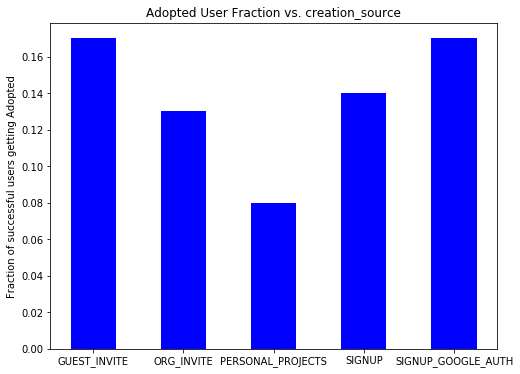

In [21]:
fig=plt.figure(figsize=(8, 6))
idx = range(5)
axes=fig.add_subplot(1, 1, 1)
plt.bar(height=creation_source_df.loc['Fraction_Positive'], x=idx, color='b', width=0.5, label='creation_source')
plt.xticks(idx, creation_source_df.columns)
plt.ylabel('Fraction of successful users getting Adopted')
plt.title('Adopted User Fraction vs. creation_source')
plt.show()

People signing up via 'GUEST_INVITE' and 'SIGNUP_GOOGLE_AUTH' have most success rate in being adopted

In [22]:
opted_in_to_mailing_list_df = users.pivot_table(index='adopted_user', columns='opted_in_to_mailing_list', values='object_id', aggfunc='count', fill_value=0)
opted_in_to_mailing_list_df.loc['Fraction_Positive'] = round(opted_in_to_mailing_list_df.loc[True]/opted_in_to_mailing_list_df.sum(), 2)
opted_in_to_mailing_list_df

opted_in_to_mailing_list,0,1
adopted_user,,
False,7818.00,2580.00
True,1188.00,414.00
Fraction_Positive,0.13,0.14


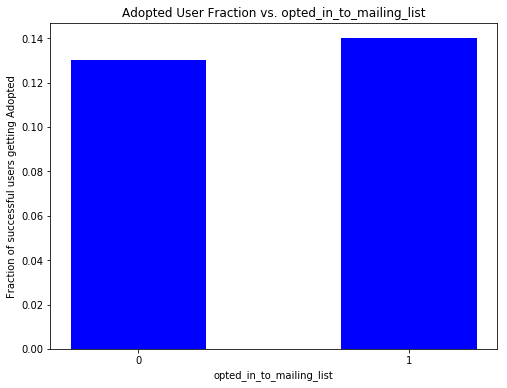

In [23]:
fig=plt.figure(figsize=(8, 6))
idx = range(2)
axes=fig.add_subplot(1, 1, 1)
plt.bar(height=opted_in_to_mailing_list_df.loc['Fraction_Positive'], x=idx, color='b', width=0.5, label='opted_in_to_mailing_list')
plt.xticks(idx, opted_in_to_mailing_list_df.columns)
plt.xlabel('opted_in_to_mailing_list')
plt.ylabel('Fraction of successful users getting Adopted')
plt.title('Adopted User Fraction vs. opted_in_to_mailing_list')
plt.show()

In [24]:
enabled_for_marketing_drip_df = users.pivot_table(index='adopted_user', columns='enabled_for_marketing_drip', values='object_id', aggfunc='count', fill_value=0)
enabled_for_marketing_drip_df.loc['Fraction_Positive'] = round(enabled_for_marketing_drip_df.loc[True]/enabled_for_marketing_drip_df.sum(), 2)
enabled_for_marketing_drip_df

enabled_for_marketing_drip,0,1
adopted_user,,
False,8852.00,1546.00
True,1356.00,246.00
Fraction_Positive,0.13,0.14


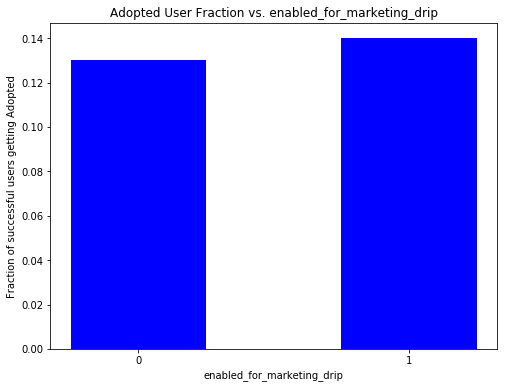

In [25]:
fig=plt.figure(figsize=(8, 6))
idx = range(2)
axes=fig.add_subplot(1, 1, 1)
plt.bar(height=enabled_for_marketing_drip_df.loc['Fraction_Positive'], x=idx, color='b', width=0.5, label='enabled_for_marketing_drip')
plt.xticks(idx, enabled_for_marketing_drip_df.columns)
plt.xlabel('enabled_for_marketing_drip')
plt.ylabel('Fraction of successful users getting Adopted')
plt.title('Adopted User Fraction vs. enabled_for_marketing_drip')
plt.show()

In [26]:
invited_by_user_df = users.pivot_table(index='adopted_user', columns='invited_by_user', values='object_id', aggfunc='count', fill_value=0)
invited_by_user_df.loc['Fraction_Positive'] = round(invited_by_user_df.loc[True]/invited_by_user_df.sum(), 2)
invited_by_user_df

invited_by_user,0,1
adopted_user,,
False,4894.00,5504.00
True,689.00,913.00
Fraction_Positive,0.12,0.14


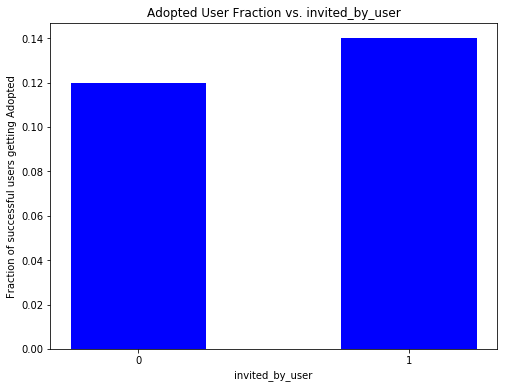

In [27]:
fig=plt.figure(figsize=(8, 6))
idx = range(2)
axes=fig.add_subplot(1, 1, 1)
plt.bar(height=invited_by_user_df.loc['Fraction_Positive'], x=idx, color='b', width=0.5, label='invited_by_user')
plt.xticks(idx, invited_by_user_df.columns)
plt.xlabel('invited_by_user')
plt.ylabel('Fraction of successful users getting Adopted')
plt.title('Adopted User Fraction vs. invited_by_user')
plt.show()

In [28]:
email_market_df = users.pivot_table(index='adopted_user', columns=['invited_by_user', 'enabled_for_marketing_drip', 'opted_in_to_mailing_list'], values='object_id', aggfunc='count', fill_value=0)
email_market_df.loc['Fraction_Positive'] = round(email_market_df.loc[True]/email_market_df.sum(), 2)
email_market_df

invited_by_user                   0                                1          \
enabled_for_marketing_drip        0               1                0           
opted_in_to_mailing_list          0       1       0       1        0       1   
adopted_user                                                                   
False                       3506.00  670.00  184.00  534.00  3922.00  754.00   
True                         488.00   90.00   30.00   81.00   640.00  138.00   
Fraction_Positive              0.12    0.12    0.14    0.13     0.14    0.15   

invited_by_user                             
enabled_for_marketing_drip       1          
opted_in_to_mailing_list         0       1  
adopted_user                                
False                       206.00  622.00  
True                         30.00  105.00  
Fraction_Positive             0.13    0.14

From the above, it looks like the 3 features - 'invited_by_user', 'enabled_for_marketing_drip', 'opted_in_to_mailing_list' doesnt have a lot of influence in them being adopted

In [29]:
org_id_df = users.pivot_table(index='adopted_user', columns='org_id', values='object_id', aggfunc='count', fill_value=0)
org_id_df.loc['Fraction_Positive'] = round(org_id_df.loc[True]/org_id_df.sum(), 2)
org_id_df.sort_values('Fraction_Positive', ascending=False, axis=1).T.head(5)

adopted_user,False,True,Fraction_Positive
org_id,,,
387,5.0,7.0,0.58
235,7.0,6.0,0.46
270,8.0,6.0,0.43
400,5.0,3.0,0.38
399,8.0,5.0,0.38


# Modeling
Let us use a simple Random Forest Classification Algorithm and see which of the features are important and how reliably we can predict whether the user is adopted or not

In [30]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited_by_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False,1


**More Feature Engineering**  
Drop the columns which wouldnt influence adopted users - 'object_id', 'creation_time', 'name', 'email', 'invited_by_user_id' (since we have converted that to invited_by_user column)

In [31]:
users_df = users.drop(['object_id', 'creation_time', 'name', 'email', 'invited_by_user_id'], axis=1)

* Fill the missing last_session_creation_time with the median. The users with missing values are not adopted. We fill in these with the median. 
* Normalize last_session_creation_time
* Convert strings to numeric categories
* Convert adopted_user to {1, 0} depending on whether it is True or False

In [32]:
median = users_df['last_session_creation_time'].median()
mean = users_df['last_session_creation_time'].mean()
creation_source_dict = {'GUEST_INVITE':0, 'ORG_INVITE':1, 'PERSONAL_PROJECTS':2, 'SIGNUP':3, 'SIGNUP_GOOGLE_AUTH':4}
adopted_user_dict = {'False': 0, 'True': 1}
min_max_scaler = preprocessing.MinMaxScaler()

users_df['last_session_creation_time'] = users_df['last_session_creation_time'].fillna(median)
users_df['last_session_creation_time'] = min_max_scaler.fit_transform(users_df['last_session_creation_time'].values.reshape(-1, 1))
users_df['creation_source'] = users_df['creation_source'].map(creation_source_dict)
users_df['adopted_user'] = users_df['adopted_user'].map({True:1, False:0})
users_df.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,invited_by_user
0,0,0.938254,1,0,11,0,1
1,1,0.908366,0,0,1,1,1
2,1,0.397434,0,0,94,0,1
3,0,0.483504,0,0,1,0,1
4,0,0.320639,0,0,193,0,1


In [33]:
X = users_df.drop('adopted_user', axis=1)
y = users_df['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X2_train, X2_test = X_train.drop('last_session_creation_time', axis=1), X_test.drop('last_session_creation_time', axis=1)

## Random Forest Classifier - with last_session_creation_time

In [34]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [100, 200, 500], 
             'max_depth': [5, 10, 20], 
             'max_features': [2, 3, 5],
             'min_samples_leaf': [1, 3, 7], 
             'min_samples_split': [2, 5, 10]}

rf_cv = RandomizedSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [100, 200, 500], 'max_depth': [5, 10, 20], 'max_features': [2, 3, 5], 'min_samples_leaf': [1, 3, 7], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Print out the Best Random Forest Hyper parameters 

In [35]:
rf_cv.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 7,
 'max_features': 2,
 'max_depth': 20}

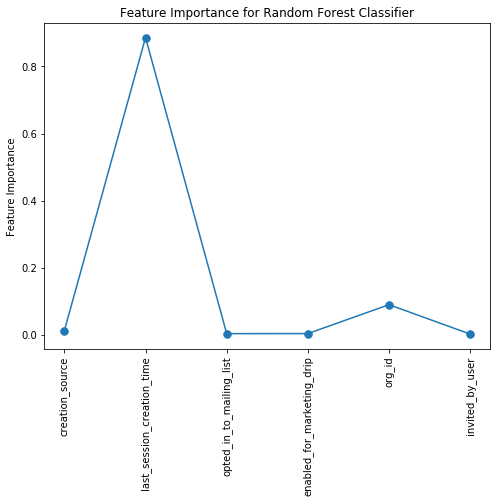

In [36]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rf_cv.best_estimator_.feature_importances_, marker='.', markersize=15)
plt.xticks(range(len(rf_cv.best_estimator_.feature_importances_)), X_train.columns, rotation=90)
axes.set(ylabel='Feature Importance', title='Feature Importance for Random Forest Classifier')
plt.show()

In [37]:
pd.DataFrame(rf_cv.best_estimator_.feature_importances_, index = X_train.columns, columns=['Feature Importance'])

,Feature Importance
creation_source,0.012770
last_session_creation_time,0.885961
opted_in_to_mailing_list,0.004078
enabled_for_marketing_drip,0.004179
org_id,0.090332
invited_by_user,0.002679


last_session_creation_time seems to have the maximum importance. Let us take a closer look at this feature

In [38]:
users_df[users_df['adopted_user']==1]['last_session_creation_time'].describe()

count    1602.000000
mean        0.900260
std         0.202643
min         0.049202
25%         0.969870
50%         0.988188
75%         0.995962
max         0.997791
Name: last_session_creation_time, dtype: float64

In [39]:
users_df[users_df['adopted_user']==0]['last_session_creation_time'].describe()

count    10398.000000
mean         0.619300
std          0.252676
min          0.000000
25%          0.461297
50%          0.698523
75%          0.757715
max          1.000000
Name: last_session_creation_time, dtype: float64

From the above two, we can see that the last_session_creation_time is low for non adopted users. This is because, they do not login for a long time. 

In [40]:
y_pred = rf_cv.predict(X_test)

In [41]:
confusion_matrix(y_test, y_pred)

array([[2013,   67],
       [ 107,  213]], dtype=int64)

In [42]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.97      0.96      2080
          1       0.76      0.67      0.71       320

avg / total       0.92      0.93      0.93      2400



## Random Forest Classifier without last_session_creation_time

In [61]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [100, 200, 500], 
             'max_depth': [5, 10, 20], 
             'max_features': [2, 3, 5],
             'min_samples_leaf': [1, 3, 7], 
             'min_samples_split': [2, 5, 10]}

rf_cv = RandomizedSearchCV(rf, param_grid, cv=5, scoring='f1')
rf_cv.fit(X2_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [100, 200, 500], 'max_depth': [5, 10, 20], 'max_features': [2, 3, 5], 'min_samples_leaf': [1, 3, 7], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [63]:
rf_cv.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 2,
 'max_depth': 20}

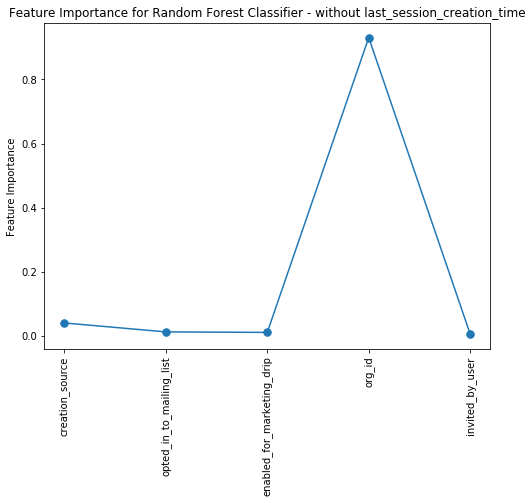

In [64]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rf_cv.best_estimator_.feature_importances_, marker='.', markersize=15)
plt.xticks(range(len(rf_cv.best_estimator_.feature_importances_)), X2_train.columns, rotation=90)
axes.set(ylabel='Feature Importance', title='Feature Importance for Random Forest Classifier - without last_session_creation_time')
plt.show()

In [65]:
pd.DataFrame(rf_cv.best_estimator_.feature_importances_, index = X2_train.columns, columns=['Feature Importance'])

,Feature Importance
creation_source,0.040340
opted_in_to_mailing_list,0.012437
enabled_for_marketing_drip,0.010902
org_id,0.930767
invited_by_user,0.005553


In [66]:
y_pred = rf_cv.predict(X2_test)

In [67]:
confusion_matrix(y_test, y_pred)

array([[2042,   38],
       [ 310,   10]], dtype=int64)

In [68]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.98      0.92      2080
          1       0.21      0.03      0.05       320

avg / total       0.78      0.85      0.81      2400

